# Analysis of OSM installations

In [1]:
import os
from pathlib import Path
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import display, Markdown

In [2]:
# Sets a bigger default size for figures
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['figure.dpi'] = 80 # 100 gives great resolution and 200 gives optimal resolution, but much slower
sns.set(rc={'figure.figsize':(12,8)})

In [3]:
pio.renderers.default = "notebook"

In [4]:
plt.style.use('fivethirtyeight')

In [5]:
## 1. Input parameters

In [6]:
install_events_uri = 'https://osm.etsi.org/stats/install-log.csv'

date_first_valid_sample = '2021-11-29'

In [7]:
skip_export_to_html = False

In [8]:
inputs_folder = 'inputs'
outputs_folder = 'outputs'
outputs_path = Path(outputs_folder)

In [9]:
relevant_releases = [
    # '11.0.0rc1',
    'ReleaseTWELVE',
    'Release TWELVE',
    'ReleaseTWELVE-daily',
    'Release TWELVE-daily',
    'ReleaseELEVEN',
    'Release ELEVEN',
    'ReleaseELEVEN-daily',
    'Release ELEVEN-daily',
    'release',
    'testing-daily'
]

In [10]:
sorted_types_of_install_events = [
    'start',
    'checks',
    'prereq',
    'docker_ce',
    'k8scluster',
    # Order to be confirmed:
    'bootstrap_k8s',
    # Order to be confirmed:
    'bootstrap_lxd',
    'juju',
    'docker_images',
    'osm_files',
    'deploy_osm',
    'osmclient',
    'healthchecks',
    'final_ops',
    'end',

    # To be sorted
    'install_microstack_ok'
]

events_to_discard = ['hola', 'hola2', 'my-event', 'my-second-event', 'test-event']

events_renaming = {
    'add_local_k8scluster': 'final_ops',
    'after_healthcheck': 'healthchecks',
    'checkingroot': 'checks',
    'deploy_osm_pla': 'deploy_osm',
    'deploy_osm_services_k8s': 'deploy_osm',
    'docker_build': 'docker_images',
    'env_files': 'osm_files',
    'init_k8s': 'k8scluster',
    'install_helm': 'k8scluster',
    'install_k8s': 'k8scluster',
    'juju_controller': 'juju',
    'juju_install': 'juju',
    'k8s_metallb': 'k8scluster',
    'k8s_ready': 'k8scluster',
    'k8s_storageclass': 'k8scluster',
    'manifest_files': 'osm_files',
    'noroot': 'checks',
    'osm_unhealthy': 'healthchecks',
    'prereqok': 'prereq',
    'proceed': 'checks'
}

sorted_types_of_install_operations = [
    'start_ok',
    'release',
    'docker_tag',
    'installation_type',
    'checkingroot_ok',
    'noroot_ok',
    'proceed_ok',
    'prereqok_ok',
    'docker_ce_ok',
    'install_k8s_ok',
    'init_k8s_ok',
    'install_helm_ok',
    'k8s_storageclass_ok',
    'k8s_metallb_ok',
    'k8s_ready_ok',
    'k8scluster_ok',
    'juju_install_ok',
    'juju_controller_ok',
    # Order to be confirmed:
    'bootstrap_k8s_ok',
    # Order to be confirmed:
    'bootstrap_lxd_ok',
    'juju_ok',
    'docker_images_ok',
    'manifest_files_ok',
    'env_files_ok',
    'deploy_charmed_services_ok',
    'kube_secrets_ok',
    'update_manifest_files_ok',
    'namespace_vol_ok',
    'deploy_osm_pla_ok',
    'deploy_osm_services_k8s_ok',
    'osmclient_ok',
    'osm_unhealthy',
    'after_healthcheck_ok',
    'add_local_k8scluster_ok',
    'end',
    'fatal',

    # To be sorted
    'apt_proxy_configured_ok',
    'install_k8s_monitoring_ok',

    'install_microstack_ok'
]

operations_to_discard = ['start', 'my-op', 'op1', 'op2', 'fatal_my-event', 'test-event', 'fatal_test-event']

operations_renaming = {
    'apt_proxy_configured': 'apt_proxy_configured_ok',
    'checkingroot': 'checkingroot_ok',
    'noroot': 'noroot_ok',
    'proceed': 'proceed_ok',
    'prereqok': 'prereqok_ok',
    'docker_ce': 'docker_ce_ok',
    'install_k8s': 'install_k8s_ok',
    'init_k8s': 'init_k8s_ok',
    'install_helm': 'install_helm_ok',
    'k8s_storageclass': 'k8s_storageclass_ok',
    'k8s_metallb': 'k8s_metallb_ok',
    'k8scluster': 'k8scluster_ok',
    'juju_controller': 'juju_controller_ok',
    'juju': 'juju_ok',
    'docker_build': 'docker_images_ok',
    'docker_build_ok': 'docker_images_ok',
    'manifest_files': 'manifest_files_ok',
    'env_files': 'env_files_ok',
    'deploy_osm_pla': 'deploy_osm_pla_ok',
    'deploy_osm_services_k8s': 'deploy_osm_services_k8s_ok',
    'osmclient': 'osmclient_ok',
    'after_healthcheck': 'after_healthcheck_ok',
    'add_local_k8scluster': 'add_local_k8scluster_ok'
}

In [11]:
today_as_datetime = pd.to_datetime("today")
today = today_as_datetime.strftime('%Y-%m-%d')

display(Markdown(f'**Date and time of the report:** {today_as_datetime}'))

**Date and time of the report:** 2022-07-05 18:49:31.160501

## 1. Loading and processing installation events

In [12]:
column_names = ['timestamp', 'location', 'queries']

In [13]:
def convert_keyvalues_to_series(df_with_keys):
    cols = df_with_keys.columns
    df_with_series = df_with_keys.copy()

    for col in cols:
        # Breaks down each column into 2 columns: keys and values
        df = df_with_keys[col].str.split('=', expand=True)

        # If there are values, adds them; else, the column should be empty
        df_with_series[col] = df[1] if (df.shape[1] == 2) else pd.NA

        # New name for the column, from the key name
        df_with_series.rename(columns={col: df.iloc[0, 0]}, inplace=True)

    return df_with_series

In [14]:
def drop_undesired_categories(df, col_name, undesired_categories):
    mask = ~ df.loc[:, col_name].isin(undesired_categories)
    return df.loc[mask].copy()

In [15]:
def fix_categories(input_serie, known_categories):
    unknown = input_serie[~ input_serie.isin(known_categories)].unique().tolist()
    return [known_categories + unknown, unknown]

def make_sorted_categorical(sr, known_categories):
    extended_categories, unknown_categories = fix_categories(sr, known_categories)
    # display(pd.Series(extended_categories).value_counts())
    new_category = CategoricalDtype(categories=extended_categories, ordered=True)
    if unknown_categories:
        print(f"Unknown categories: {unknown_categories}")
    return sr.astype(new_category)

def remove_spurious_columns(df):
    # Removes any spurious (`None`) columns as result from malformed queries
    return df.loc[:, [col for col in df.columns if col]]

In [16]:
def load_install_events_and_operations():
    # df_raw_install_events = pd.read_csv(install_events_uri, sep=';', header=0, names=column_names, skiprows=120)
    # df_raw_install_events = pd.read_csv(install_events_uri, sep=';', header=0, names=column_names, skiprows=15139)
    df_raw_install_events = pd.read_csv(
        install_events_uri,
        sep=';',
        header=0,
        names=column_names,
        skiprows=120,
        error_bad_lines=False
    )

    return (
        df_raw_install_events
        .drop(columns='queries')
        .join(
            (
                df_raw_install_events
                ['queries']
                .str.split('&', expand=True)
                .drop(columns=0)    # 1st column should be empty due to `&`
                .pipe(convert_keyvalues_to_series)
            )
        )

        # Empty strings should be NA
        .replace("", pd.NA)

        # Removes malformed lines ('installation_id' will be missing, among others)
        .dropna(subset=['installation_id'])

        # Removes lines with undesired 'event' or 'operation' categories
        .pipe(drop_undesired_categories, 'event', events_to_discard)
        .pipe(drop_undesired_categories, 'operation', operations_to_discard)

        # Replaces values of old 'event' or 'operation' categories by their new names
        .assign(event = lambda x: x.event.replace(events_renaming))
        .assign(operation = lambda x: x.operation.replace(operations_renaming))

        # If within the same installation attempt we have a duplicate 'operation', only last sample is kept
        .drop_duplicates(subset=['installation_id', 'operation'], keep='last')

        # Drops lines with NA in `event` or `operation`
        .dropna(subset=['event', 'operation'])

        # Fixes data types
        # .assign(timestamp = lambda x: pd.to_datetime(x.timestamp))
        .assign(timestamp = lambda x: pd.to_datetime(x.timestamp, errors='coerce'))
        .dropna(subset=['timestamp'])
        .assign(location = lambda x: x.location.astype('category'))
        .assign(event = lambda x: make_sorted_categorical(x.event, sorted_types_of_install_events))
        .assign(operation = lambda x: make_sorted_categorical(x.operation, sorted_types_of_install_operations))

        # Removes any spurious (`None`) columns as result from malformed queries
        .pipe(remove_spurious_columns)
    )

In [17]:
# load_install_events_and_operations()

In [18]:
df_install_events_and_operations = (
    load_install_events_and_operations()
    .query("timestamp >= @date_first_valid_sample")
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version.



b'Skipping line 12697: expected 3 fields, saw 12\nSkipping line 12959: expected 3 fields, saw 10\nSkipping line 12960: expected 3 fields, saw 10\nSkipping line 31746: expected 3 fields, saw 5\nSkipping line 33238: expected 3 fields, saw 10\nSkipping line 34063: expected 3 fields, saw 12\nSkipping line 34326: expected 3 fields, saw 5\nSkipping line 35706: expected 3 fields, saw 5\nSkipping line 35814: expected 3 fields, saw 5\nSkipping line 36971: expected 3 fields, saw 5\nSkipping line 67445: expected 3 fields, saw 10\n'


In [19]:
# Uncomment For CSV debugging
#
# !wget -N ${install_events_uri}
#
## Uncomment to extract specific line
##!awk "{if(NR==36972) print $0}" install-log.csv

In [20]:
# Uncomment To force removal of unknown categories if needed
#
# mask = df_install_events.event.isin(sorted_types_of_install_events) & df_install_events.operation.isin(sorted_types_of_install_operations)
# df_install_events = df_install_events.loc[mask]

In [21]:
# df_install_events_and_operations.info()

In [22]:
# df_install_events_and_operations.location.value_counts()

In [23]:
# df_install_events_and_operations.head()

In [24]:
##############################
## 2. Preprocessing
##############################

In [25]:
# Organization in wide format

In [26]:
def get_achieved_operations(df):
    return (
        pd.concat(
            [
                # All operations that explicitly show progress in the installation
                (
                    df
                    .assign(value = lambda x: x.value.fillna(True))
                    .query("value == True")
                    .rename(columns={'operation': 'achievement'})
                    .drop(columns='value')
                ),

                # Adds extra rows to flag the beginning of the installation
                (
                    df
                    .query("(event == 'start') & (operation == 'release')")
                    .assign(operation = 'start_ok')
                    .rename(columns={'operation': 'achievement'})
                    .drop(columns='value')
                )
            ]
        )
        .sort_index()
        .assign(achievement = lambda x: make_sorted_categorical(x.achievement, sorted_types_of_install_operations).cat.remove_unused_categories())
    )

In [27]:
df_achieved_operations = get_achieved_operations(df_install_events_and_operations)

In [28]:
# df_achieved_operations.info()

In [29]:
# df_achieved_operations.head()

In [30]:
def cast_axis_to_str(df):
    df.columns = df.columns.astype(str)
    return df

def remove_column_axis_name(df):
    df.columns.name = None
    return df

def get_info_operations_wide(df):
    return (
        df
        .loc[:, ['installation_id', 'operation', 'value']]
        .assign(value = lambda x: x.value.fillna(True))
        .query("value != True")
        .pivot(
            index = 'installation_id',
            columns = 'operation',
            values = 'value'
        )
        .pipe(cast_axis_to_str)
        .pipe(remove_column_axis_name)
        .reset_index()
    )

In [31]:
df_info_operations_wide = get_info_operations_wide(df_install_events_and_operations)

In [32]:
# df_info_operations_wide.info()

In [33]:
# df_info_operations_wide.head()

In [34]:
# df_install_events_and_operations.query("operation == 'fatal'")

In [35]:
# df_info_operations_wide[~ df_info_operations_wide.fatal.isna()]

In [36]:
df_installations_wide = (
    df_achieved_operations
    .merge(
        df_info_operations_wide,
        how = 'left',
        on = 'installation_id'
    )
)

In [37]:
# Uncomment to dump the dataframe as Excel file
#
# df_installations_wide.to_excel('df_installations_wide.xlsx')

In [38]:
# df_installations_wide.info()

In [39]:
# df_installations_wide.head()

In [40]:
# df_installations_wide.tail()

## 2. Number of installations

In [41]:
# Uncomment to check if external vs. internal installations are distinguished
#
# df_installations_wide.location.value_counts()

### 2.1 Number of installations per release

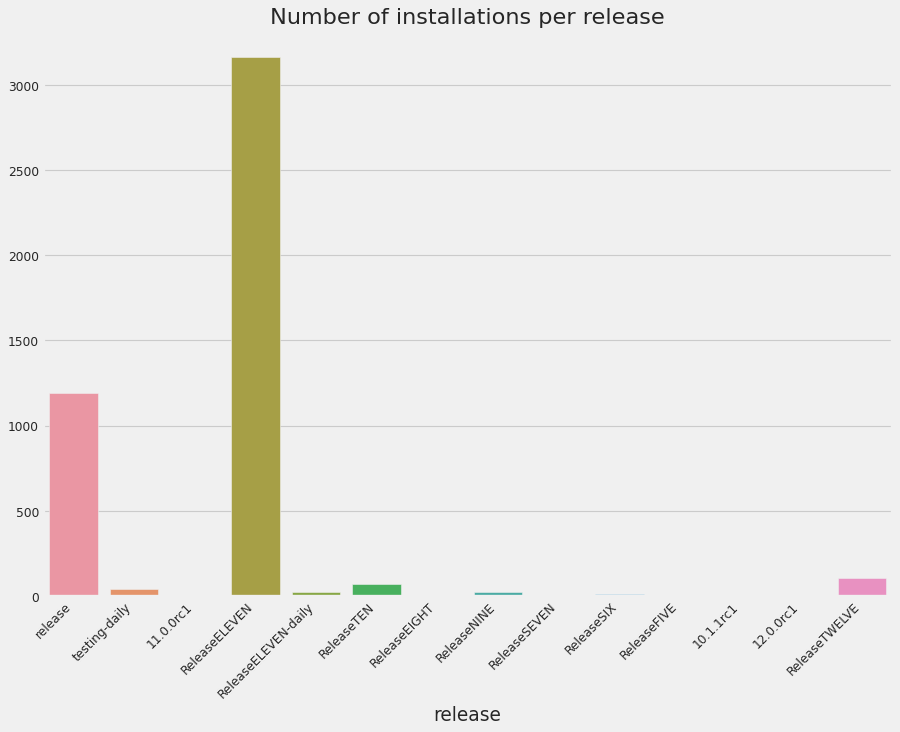

In [42]:
sns.countplot(
    # data = df_installations_wide.drop_duplicates(subset='installation_id'),
    data = df_installations_wide.drop_duplicates(subset='installation_id').loc[:, 'release'].to_frame(),
    x = 'release',
)

plt.tight_layout()
plt.xticks(rotation=45, ha='right')

plt.title('Number of installations per release')
plt.ylabel(None)

plt.show()

In [43]:
# Companion table with number of installations per release
(
    df_installations_wide
    .drop_duplicates(subset='installation_id')
    .release
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={'release': 'INSTALLATIONS', 'index': 'RELEASE'})
)

RELEASE  INSTALLATIONS
0         ReleaseELEVEN           3164
1               release           1191
2         ReleaseTWELVE            104
3            ReleaseTEN             69
4         testing-daily             42
5           ReleaseNINE             25
6   ReleaseELEVEN-daily             21
7            ReleaseSIX              9
8          ReleaseEIGHT              7
9           ReleaseFIVE              3
10            12.0.0rc1              3
11         ReleaseSEVEN              2
12            10.1.1rc1              2
13            11.0.0rc1              1

### 2.2 Temporal evolution of installations

In [44]:
df_installations_per_week = (
    df_installations_wide
    .drop_duplicates(subset='installation_id')
    # .resample('W-MON', on='timestamp')
    .groupby(
        [pd.Grouper(key='timestamp', freq='W-MON'), 'release']
    )
    .installation_id
    .count()
    .reset_index()
    .rename({'installation_id': 'weekly_installations'}, axis=1)
    .assign(total_installations = lambda x: x.groupby('release').weekly_installations.cumsum())
)

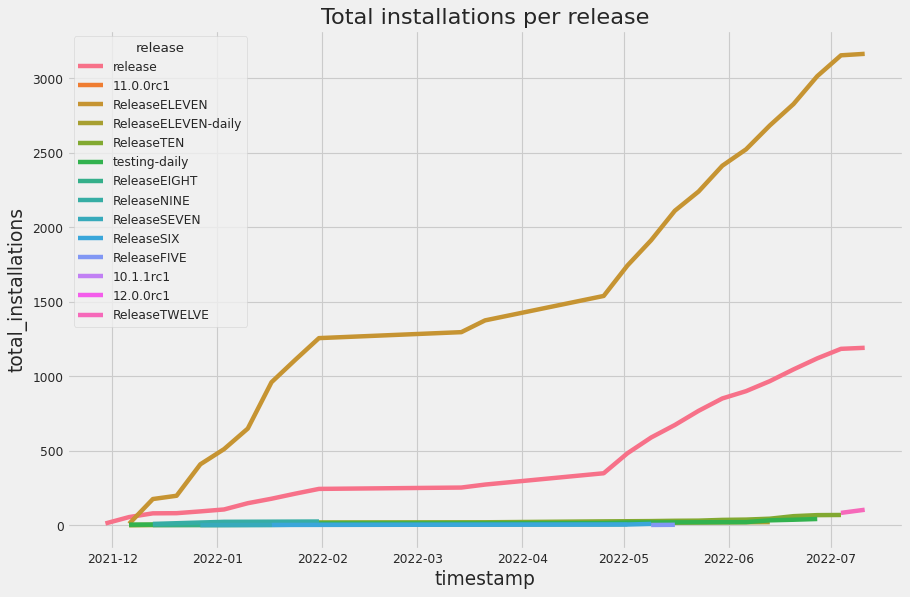

In [45]:
sns.lineplot(
    data = df_installations_per_week,
    x = 'timestamp',
    y = 'total_installations',
    hue = 'release',
)

plt.title('Total installations per release')

plt.show()

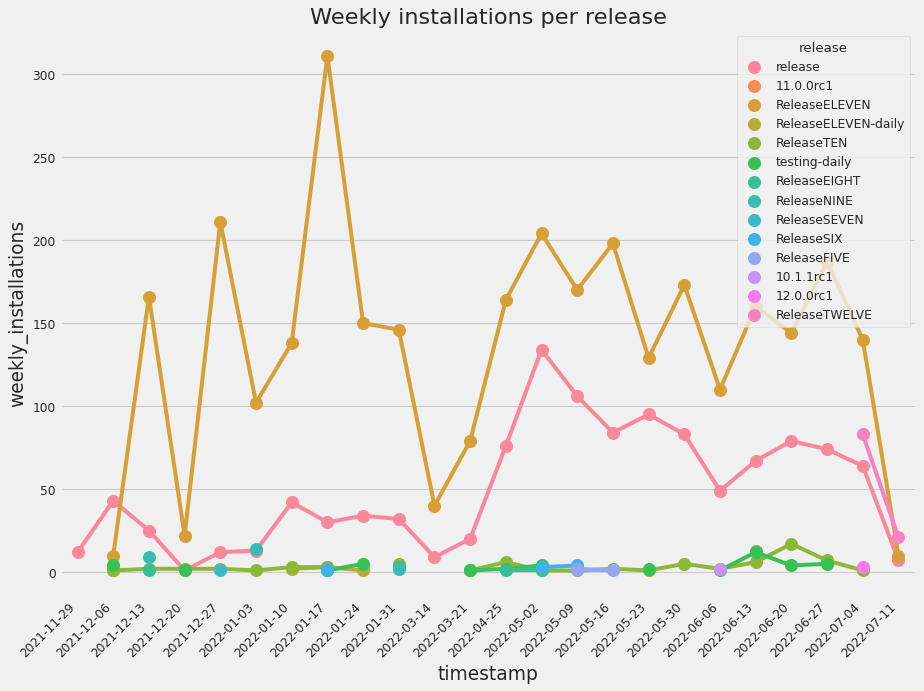

In [46]:
sns.pointplot(
    data = (
        df_installations_per_week
        .assign(timestamp = lambda x: x.timestamp.astype(str))
    ),
    x = 'timestamp',
    y = 'weekly_installations',
    hue = 'release',
    scale = 0.5,
)

plt.tight_layout()
plt.xticks(rotation=45, ha='right')

plt.title('Weekly installations per release')

plt.show()

Summary as of the week of the last sample per release:

In [47]:
# Companion table of installations
df_installations_per_week.groupby('release').last().sort_values('total_installations', ascending=False).reset_index()

release  timestamp  weekly_installations  total_installations
0         ReleaseELEVEN 2022-07-11                    10                 3164
1               release 2022-07-11                     7                 1191
2         ReleaseTWELVE 2022-07-11                    21                  104
3            ReleaseTEN 2022-07-04                     1                   69
4         testing-daily 2022-06-27                     5                   42
5           ReleaseNINE 2022-01-31                     2                   25
6   ReleaseELEVEN-daily 2022-06-13                    13                   21
7            ReleaseSIX 2022-05-09                     4                    9
8          ReleaseEIGHT 2022-05-02                     1                    7
9             12.0.0rc1 2022-07-04                     3                    3
10          ReleaseFIVE 2022-05-16                     1                    3
11            10.1.1rc1 2022-06-06                     2                    2
12         ReleaseSEVEN 2022-01-17                     1                    2
13            11.0.0rc1 2021-12-06                     1                    1

Detail of weekly installations per release (last 36 weeks):

In [48]:
(
    df_installations_per_week
    # .query("release.isin(@relevant_releases)")
    .loc[df_installations_per_week.release.isin(relevant_releases)]
    .drop(columns = 'total_installations')
    .pivot_table(
        index = 'timestamp',
        columns = 'release'
    )
    .fillna(0)
    .astype('int')
).tail(36)

weekly_installations                                            \
release           ReleaseELEVEN ReleaseELEVEN-daily ReleaseTWELVE release   
timestamp                                                                   
2021-11-29                    0                   0             0      12   
2021-12-06                   10                   1             0      43   
2021-12-13                  166                   0             0      25   
2021-12-20                   22                   0             0       1   
2021-12-27                  211                   0             0      12   
2022-01-03                  102                   0             0      13   
2022-01-10                  138                   2             0      42   
2022-01-17                  311                   3             0      30   
2022-01-24                  150                   1             0      34   
2022-01-31                  146                   0             0      32   
2022-03-14                   40                   0             0       9   
2022-03-21                   79                   1             0      20   
2022-04-25                  164                   0             0      76   
2022-05-02                  204                   0             0     134   
2022-05-09                  170                   0             0     106   
2022-05-16                  198                   0             0      84   
2022-05-23                  129                   0             0      95   
2022-05-30                  173                   0             0      83   
2022-06-06                  110                   0             0      49   
2022-06-13                  160                  13             0      67   
2022-06-20                  144                   0             0      79   
2022-06-27                  187                   0             0      74   
2022-07-04                  140                   0            83      64   
2022-07-11                   10                   0            21       7   

                          
release    testing-daily  
timestamp                 
2021-11-29             0  
2021-12-06             4  
2021-12-13             0  
2021-12-20             1  
2021-12-27             0  
2022-01-03             0  
2022-01-10             0  
2022-01-17             1  
2022-01-24             5  
2022-01-31             0  
2022-03-14             0  
2022-03-21             1  
2022-04-25             2  
2022-05-02             4  
2022-05-09             0  
2022-05-16             0  
2022-05-23             2  
2022-05-30             0  
2022-06-06             1  
2022-06-13            12  
2022-06-20             4  
2022-06-27             5  
2022-07-04             0  
2022-07-11             0

## 3. Progress during installation

### 3.1 Overview of successful installation steps

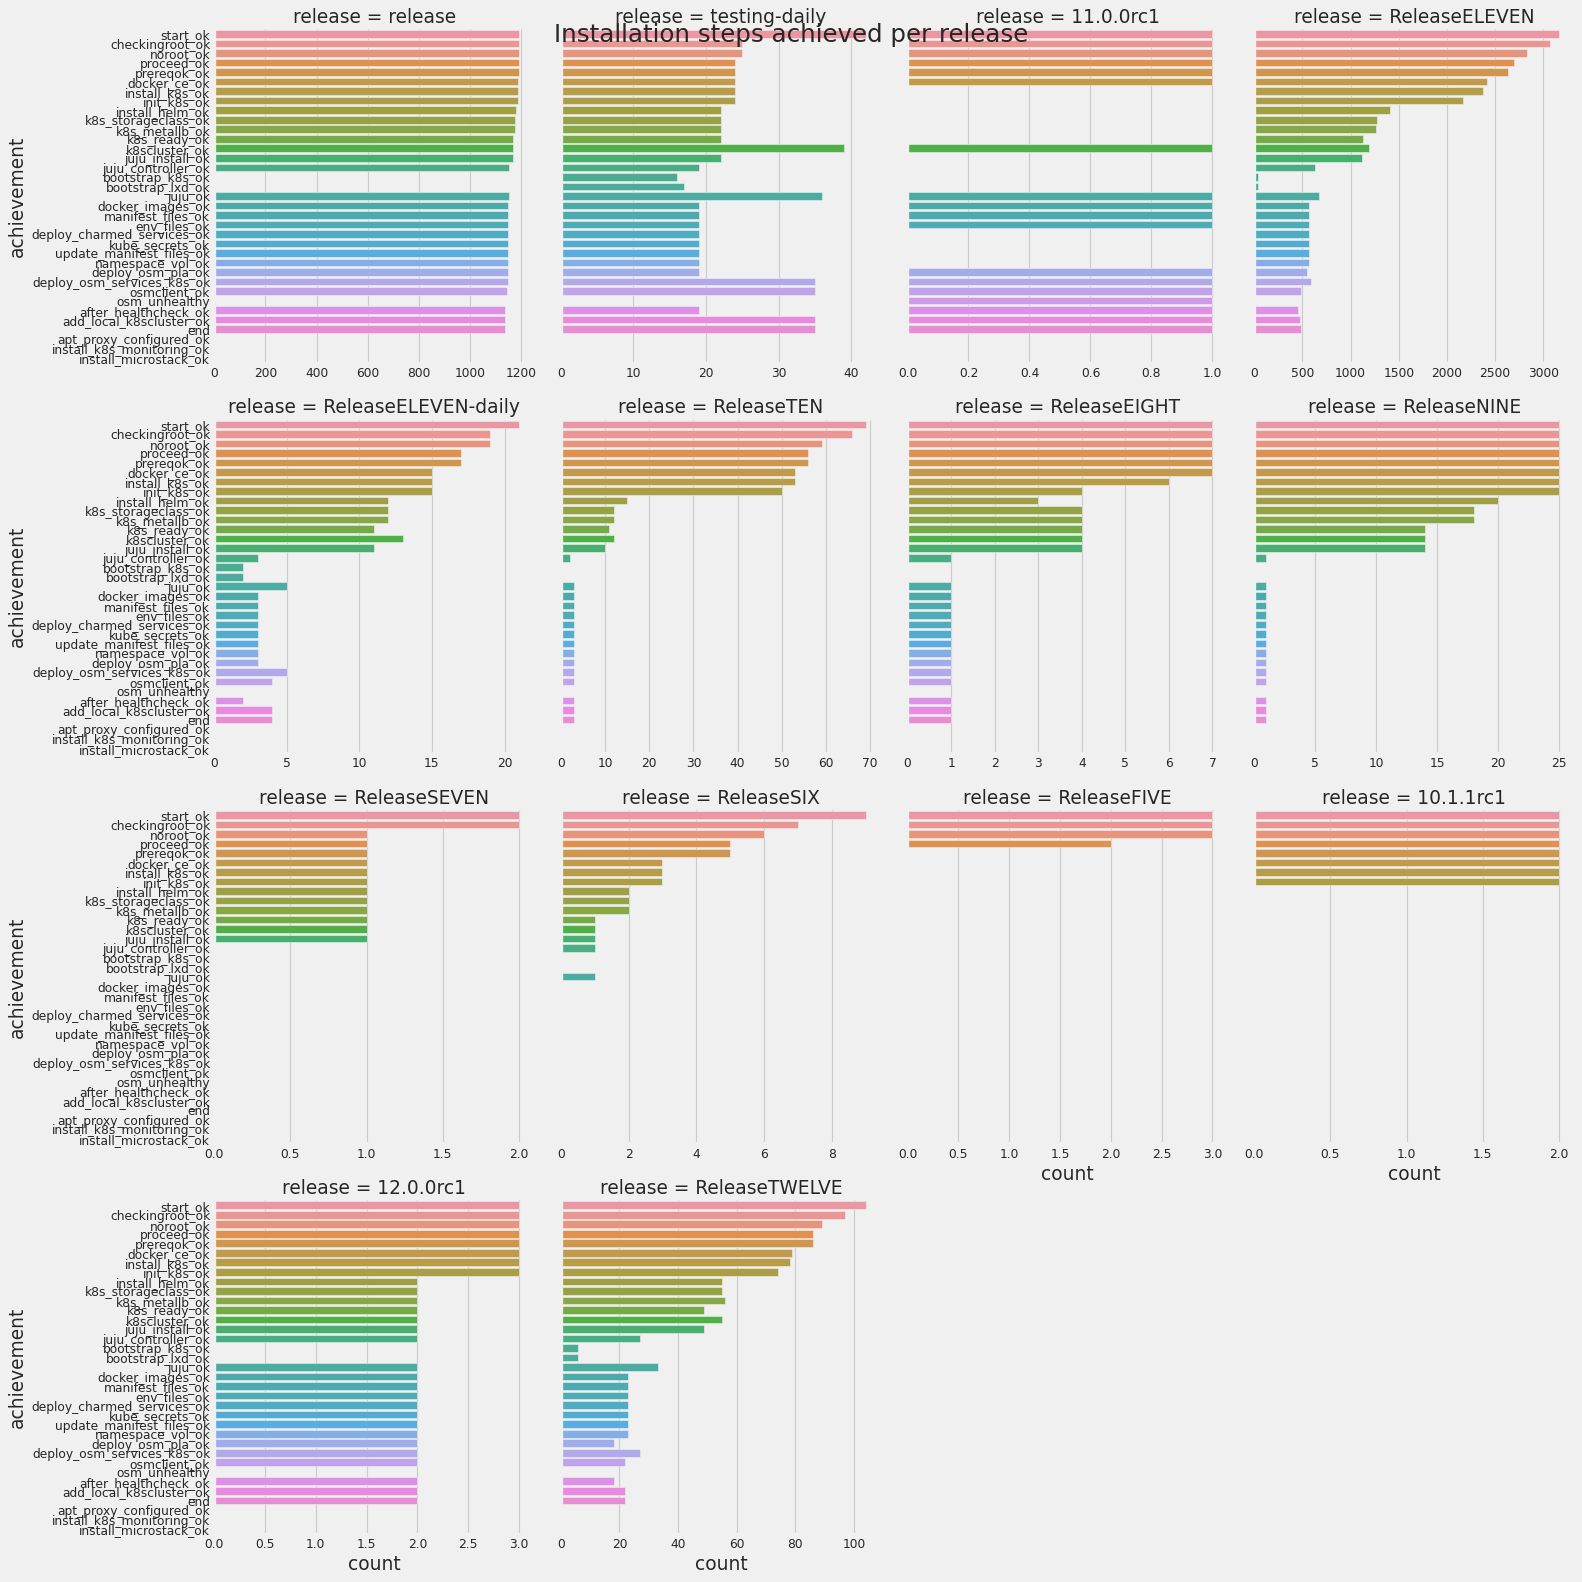

In [49]:

ax = sns.catplot(
    # data = df_installations_wide,
    data = df_installations_wide.loc[:, ['release', 'achievement']],
    y = 'achievement',
    col = 'release',
    col_wrap = 4,
    kind = 'count',
    sharex = False
)

ax.fig.suptitle('Installation steps achieved per release\n\n', fontsize = 22)
ax.tight_layout()

plt.show()

In [50]:
# TODO: Apply at the beginning of the notebook and adapt next processing steps accordingly
name_mappings = {
    'ReleaseTWELVE': 'Release TWELVE',
    'ReleaseTWELVE-daily': 'Release TWELVE-daily',
    'ReleaseELEVEN': 'Release ELEVEN',
    'ReleaseELEVEN-daily': 'Release ELEVEN-daily'
}

In [51]:
def add_pct(df):
    return (
        df
        .assign(percentage =
            (
                df
                # .groupby(['release'])['count']
                .groupby(['release', 'installation_type'])['count']

                # TODO: Remove if mapping is applied at the beginning of the notebook
                .transform(lambda x: x / x.max())
            )
        )
    )

In [52]:
# df_installations_wide.tail()

### 3.2 Installation funnels per release

In [53]:
# df_installations_wide.head()

In [54]:
def get_funnels_per_release(df_installations_wide):
    return (
        df_installations_wide
        # .groupby(['achievement', 'release'])
        .groupby(['achievement', 'release', 'installation_type'])
        .installation_id
        .count()
        .reset_index()
        .rename(columns={'installation_id': 'count'})
        .replace({'release': name_mappings})
        .pipe(add_pct)
        # .fillna(0)
        .fillna(value = {'percentage': 0})
    )

In [55]:
df_funnels_per_release = get_funnels_per_release(df_installations_wide)

In [56]:
# df_funnels_per_release.info()

In [57]:
# df_funnels_per_release.tail()

In [58]:
# df_funnels_per_release

In [59]:
def plot_funnel(df_funnel, x='count', title=None, filename=None):

    df = (
        df_funnel
        .query("achievement != 'osm_unhealthy'")
        .assign(achievement = lambda x: x.achievement.cat.remove_unused_categories())
        .query("count > 0 | (achievement == 'start_ok') | (achievement == 'end')")
    )

    fig = px.funnel(
        df,
        x = x,
        y = 'achievement',
        title = title
    )

    fig.update_layout(
        width = 800,
        height = 1200,
        title_font_size = 24,
        title_font_family = "Arial",
        # paper_bgcolor="LightSteelBlue",
    )

    fig.update_traces(
        textinfo="value+percent initial",
        textposition = "inside"
    )

    if filename:
        # TODO:
        # fig.write_image("images/fig1.png")
        pass

    fig.show()

In [60]:
# list(pio.templates)

In [61]:
# OPTIONS:
# - 'ggplot2'
# - 'seaborn'
# - 'simple_white'
# - 'plotly'
# - 'plotly_white'
# - 'plotly_dark'
# - 'presentation'
# - 'xgridoff'
# - 'ygridoff'
# - 'gridon'
# - 'none'

pio.templates.default = "seaborn"
# pio.templates.default = "plotly_white"


In [62]:
# df_funnels_per_release.head()

In [63]:
# funnels_per_release = df_funnels_per_release.groupby('release')

# # releases_to_plot = [release for release in df_funnels_per_release.release.unique() if release in relevant_releases]
# releases_to_plot = [release for release in relevant_releases if release in df_funnels_per_release.release.unique()]

# for release in releases_to_plot:
#     df_funnel = funnels_per_release.get_group(release)
#     display(
#         _ = plot_funnel(
#             df_funnel,
#             x = 'count',
#             title = f'Funnel of {release} installations'
#         )
#     )

In [64]:
for installation_type in ['Default', 'Charmed']:

    funnels_per_release = df_funnels_per_release.query("installation_type == @installation_type").groupby('release')

    # releases_to_plot = [release for release in df_funnels_per_release.release.unique() if release in relevant_releases]
    releases_to_plot = [release for release in relevant_releases if release in df_funnels_per_release.release.unique()]

    for release in releases_to_plot:
        df_funnel = funnels_per_release.get_group(release)
        display(
            _ = plot_funnel(
                df_funnel,
                x = 'count',
                title = f'Funnel of {release} installations ({installation_type.lower()} installer)'
            )
        )

In [65]:
# Companion tables of funnels
for installation_type in ['Default', 'Charmed']:

    print(f"\n{installation_type} installer:")
    display(
        df_funnels_per_release
        .query("installation_type == @installation_type")
        .query("achievement == 'end' or achievement == 'start_ok'")
        .drop(columns='percentage')
        .pivot(
            index = 'release',
            values = 'count',
            columns = 'achievement'
            # columns = ['installation_type', 'achievement']
        )
        .pipe(cast_axis_to_str)
        .reset_index()
        .pipe(remove_column_axis_name)
        .rename(columns = {'release': 'RELEASE', 'start_ok': 'TOTAL_INSTALLS', 'end': 'SUCCESSFUL_INSTALLS'})
        .assign(SUCCESS_RATIO = lambda x: (x.SUCCESSFUL_INSTALLS / x.TOTAL_INSTALLS).fillna(0))
    )


Default installer:


RELEASE  TOTAL_INSTALLS  SUCCESSFUL_INSTALLS  SUCCESS_RATIO
0              10.1.1rc1               2                    0       0.000000
1              11.0.0rc1               0                    0       0.000000
2              12.0.0rc1               3                    2       0.666667
3         Release ELEVEN            3078                  453       0.147173
4   Release ELEVEN-daily              19                    2       0.105263
5         Release TWELVE              97                   18       0.185567
6           ReleaseEIGHT               7                    1       0.142857
7            ReleaseFIVE               3                    0       0.000000
8            ReleaseNINE              25                    1       0.040000
9           ReleaseSEVEN               2                    0       0.000000
10            ReleaseSIX               8                    0       0.000000
11            ReleaseTEN              67                    3       0.044776
12               release            1191                 1137       0.954660
13         testing-daily              25                   19       0.760000


Charmed installer:


RELEASE  TOTAL_INSTALLS  SUCCESSFUL_INSTALLS  SUCCESS_RATIO
0              10.1.1rc1               0                    0       0.000000
1              11.0.0rc1               0                    0       0.000000
2              12.0.0rc1               0                    0       0.000000
3         Release ELEVEN              74                   28       0.378378
4   Release ELEVEN-daily               2                    2       1.000000
5         Release TWELVE               6                    4       0.666667
6           ReleaseEIGHT               0                    0       0.000000
7            ReleaseFIVE               0                    0       0.000000
8            ReleaseNINE               0                    0       0.000000
9           ReleaseSEVEN               0                    0       0.000000
10            ReleaseSIX               0                    0       0.000000
11            ReleaseTEN               2                    0       0.000000
12               release               0                    0       0.000000
13         testing-daily              17                   16       0.941176

## 4. Analysis of failed installation attempts

In [66]:
df_fatal_errors = (
    df_installations_wide
    .query("event == 'start'")
    [['location', 'release', 'installation_type', 'fatal', 'installation_id']]
    .groupby(['location', 'release', 'installation_type', 'fatal'], dropna=False)
    .count()
    .reset_index()
    .rename(columns = {'installation_id': 'count'})
    .assign(installation_type = lambda x: x.installation_type.fillna('Other'))
)

In [67]:
# df_fatal_errors.info()

In [68]:
# df_fatal_errors.tail()

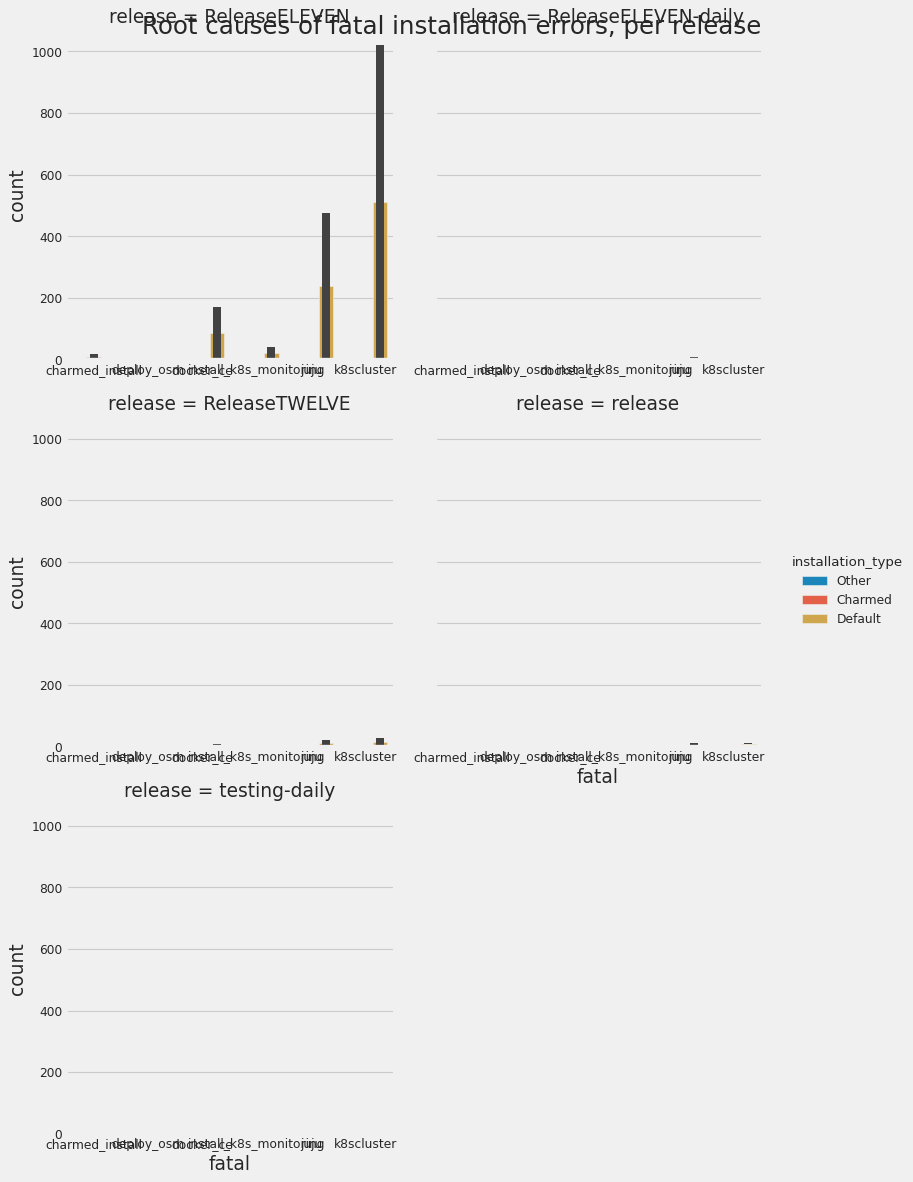

In [69]:
ax = sns.catplot(
    # data = df_fatal_errors,
    data = df_fatal_errors[df_fatal_errors.release.isin(relevant_releases)],
    y = 'count',
    x = 'fatal',
    hue = 'installation_type',
    col = 'release',
    col_wrap = 2,
    kind = 'bar',
    sharex = False
)

ax.fig.suptitle('Root causes of fatal installation errors, per release\n\n', fontsize = 22)
ax.tight_layout()

plt.show()

In [70]:
# Companion table
df_fatal_errors.pivot_table(
    index = ['location', 'release'],
    columns = ['installation_type', 'fatal'],
    values = 'count'
)

installation_type                    Charmed                       \
fatal                        charmed_install deploy_osm docker_ce   
location release                                                    
local    10.1.1rc1                         0          0         0   
         11.0.0rc1                         0          0         0   
         12.0.0rc1                         0          0         0   
         ReleaseEIGHT                      0          0         0   
         ReleaseELEVEN                     0          0         0   
         ReleaseELEVEN-daily               0          0         0   
         ReleaseFIVE                       0          0         0   
         ReleaseNINE                       0          0         0   
         ReleaseSEVEN                      0          0         0   
         ReleaseSIX                        0          0         0   
         ReleaseTEN                        0          0         0   
         ReleaseTWELVE                     0          0         0   
         release                           0          0         0   
         testing-daily                     0          0         0   
public   10.1.1rc1                         0          0         0   
         11.0.0rc1                         0          0         0   
         12.0.0rc1                         0          0         0   
         ReleaseEIGHT                      0          0         0   
         ReleaseELEVEN                    17          1         0   
         ReleaseELEVEN-daily               0          0         0   
         ReleaseFIVE                       0          0         0   
         ReleaseNINE                       0          0         0   
         ReleaseSEVEN                      0          0         0   
         ReleaseSIX                        0          0         0   
         ReleaseTEN                        1          0         0   
         ReleaseTWELVE                     0          0         0   
         release                           0          0         0   
         testing-daily                     0          0         0   

installation_type                                                    \
fatal                        install_k8s_monitoring juju k8scluster   
location release                                                      
local    10.1.1rc1                                0    0          0   
         11.0.0rc1                                0    0          0   
         12.0.0rc1                                0    0          0   
         ReleaseEIGHT                             0    0          0   
         ReleaseELEVEN                            0    0          0   
         ReleaseELEVEN-daily                      0    0          0   
         ReleaseFIVE                              0    0          0   
         ReleaseNINE                              0    0          0   
         ReleaseSEVEN                             0    0          0   
         ReleaseSIX                               0    0          0   
         ReleaseTEN                               0    0          0   
         ReleaseTWELVE                            0    0          0   
         release                                  0    0          0   
         testing-daily                            0    0          0   
public   10.1.1rc1                                0    0          0   
         11.0.0rc1                                0    0          0   
         12.0.0rc1                                0    0          0   
         ReleaseEIGHT                             0    0          0   
         ReleaseELEVEN                            0    0          0   
         ReleaseELEVEN-daily                      0    0          0   
         ReleaseFIVE                              0    0          0   
         ReleaseNINE                              0    0          0   
         ReleaseSEVEN                             0    0          0   
         Relea

In [71]:
df_unhealthy_installs = (
    df_installations_wide
    .query("event == 'start'")
    [['location', 'release', 'installation_type', 'osm_unhealthy', 'installation_id']]
    .groupby(['location', 'release', 'installation_type', 'osm_unhealthy'], dropna=False)
    .count()
    .reset_index()
    .rename(columns = {'installation_id': 'count'})
    .assign(installation_type = lambda x: x.installation_type.fillna('Other'))
)

In [72]:
# df_unhealthy_installs.info()

In [73]:
# df_unhealthy_installs.tail()

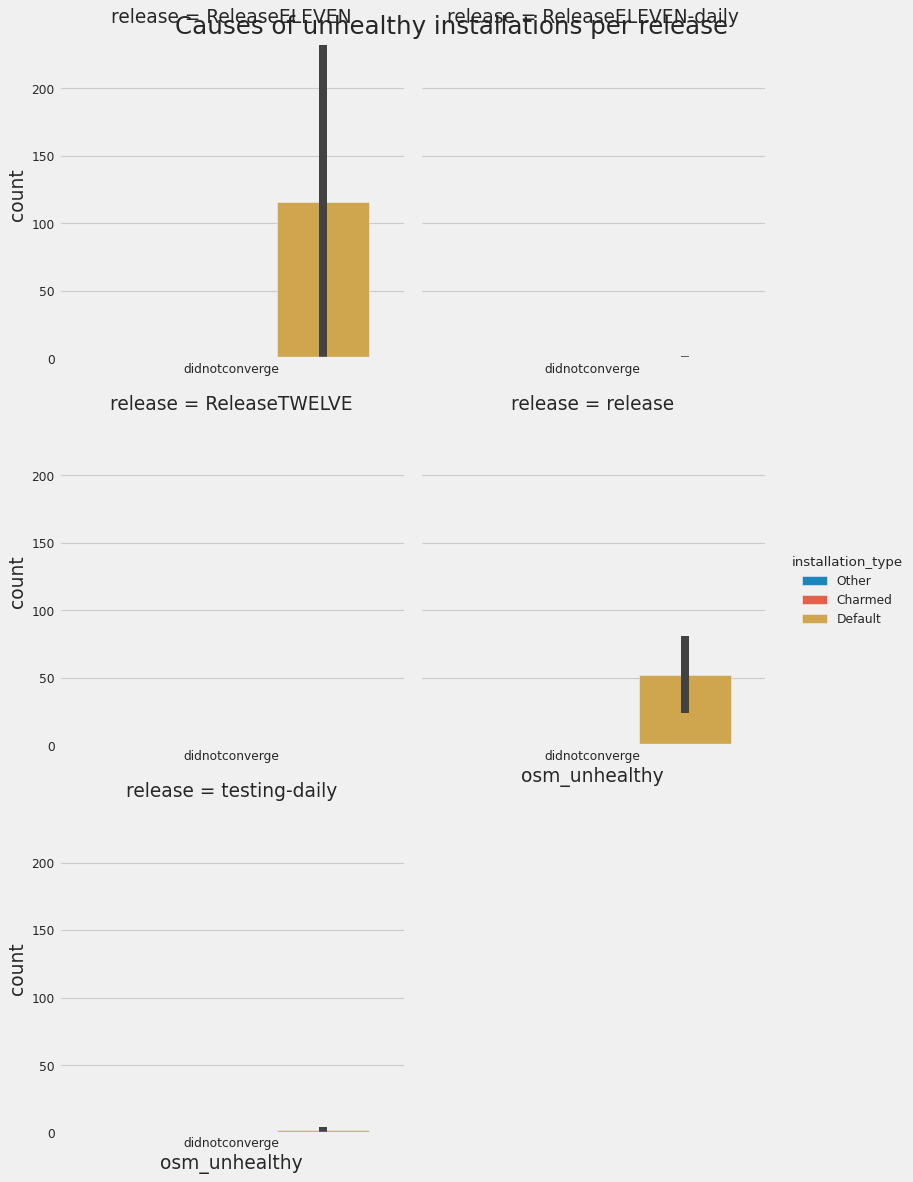

In [74]:
ax = sns.catplot(
    data = df_unhealthy_installs[df_unhealthy_installs.release.isin(relevant_releases)],
    y = 'count',
    x = 'osm_unhealthy',
    hue = 'installation_type',
    col = 'release',
    col_wrap = 2,
    kind = 'bar',
    sharex = False,
)

ax.fig.suptitle('Causes of unhealthy installations per release\n\n', fontsize = 22)

ax.tight_layout()

plt.show()

In [75]:
# Companion table of unhealthy installations
df_unhealthy_installs.pivot_table(
    index = ['location', 'release'],
    columns = ['installation_type', 'osm_unhealthy'],
    values = 'count'
)

installation_type                   Charmed        Default          Other
osm_unhealthy                didnotconverge didnotconverge didnotconverge
location release                                                         
local    10.1.1rc1                        0              0              0
         11.0.0rc1                        0              0              0
         12.0.0rc1                        0              0              0
         ReleaseEIGHT                     0              0              0
         ReleaseELEVEN                    0              0              0
         ReleaseELEVEN-daily              0              0              0
         ReleaseFIVE                      0              0              0
         ReleaseNINE                      0              0              0
         ReleaseSEVEN                     0              0              0
         ReleaseSIX                       0              0              0
         ReleaseTEN                       0              0              0
         ReleaseTWELVE                    0              0              0
         release                          0             24              0
         testing-daily                    0              0              0
public   10.1.1rc1                        0              0              0
         11.0.0rc1                        0              0              0
         12.0.0rc1                        0              0              0
         ReleaseEIGHT                     0              1              0
         ReleaseELEVEN                    0            232              0
         ReleaseELEVEN-daily              0              2              0
         ReleaseFIVE                      0              0              0
         ReleaseNINE                      0              1              0
         ReleaseSEVEN                     0              0              0
         ReleaseSIX                       0              0              0
         ReleaseTEN                       0              3              0
         ReleaseTWELVE                    0              1              0
         release                          0             81              0
         testing-daily                    0              4              0

## ANNEX: Analysis of anomalies in progress tracking logs

In [76]:
# Obtais a matrix of achievements of installations per release and type of installer
# Returns a dataframe where:
# - Index: `installation_id`
# - Columns: `achievement`
# - Values: 1 if achieved; 0 otherwise.
def get_achievement_matrix_per_install_type(df_installations_wide, release, installer):
  return (
      df_installations_wide
      .query("(release == @release) and (installation_type == @installer)")
      .assign(achievement = lambda x: x.achievement.cat.remove_unused_categories())
      .pivot_table(
          index = 'installation_id',
          columns = 'achievement',
          values = 'timestamp',
          aggfunc = 'count'
      )
      .pipe(remove_column_axis_name)
  )
  
# Obtains a matrix of changes in a given matrix of installation sequences (for one release and one installer)
# Returns a dataframe where:
# - Index: `installation_id`
# - Columns: `achievement`
# - Values: 1 if changed; 0 otherwise.
def get_changes_in_installation_sequence(df):
  return df.T.apply(lambda x: (x != x.shift()).astype(int)).T

# get_changes_in_installation_sequence(df)

# # Number of changes per installation attempt
# get_changes_in_installation_sequence(df).T.sum(axis=0) - 1

# Obtains a matrix of DOUBLE CHANGES in a given matrix of installation sequences (for one release and one installer)
# - THESE ARE A SIGN OF ERRORS IN THE TRACKING
# Returns a dataframe where:
# - Index: `installation_id`
# - Columns: `achievement`
# - Values: 1 if double change; 0 otherwise.
def get_double_changes_in_installation_sequence(df):
  return (
    df.T
    .apply(lambda x: ((x != x.shift()) & (x != x.shift(-1))).astype(int))
    .T
    .assign(start_ok = 0)
    .assign(end = 0)
  )
 

def plot_double_changes_per_operation(double_changes_per_operation, title):

  fig, ax = plt.subplots(figsize = (7,10))
  # fig, ax = plt.subplots()

  sns.barplot(
      data = double_changes_per_operation,
      y = 'operation',
      x = 'number_double_changes',
      ci = None,
      ax = ax,
      order = (
          double_changes_per_operation
          .sort_values('number_double_changes', ascending=False)
          .operation
      )
  )

  # fig.suptitle(title, fontsize=20)
  ax.set_title(title, fontsize=18)
  ax.set_xlabel('Number of double changes')
  ax.set_ylabel('Operation')
  fig.tight_layout()

  plt.show()

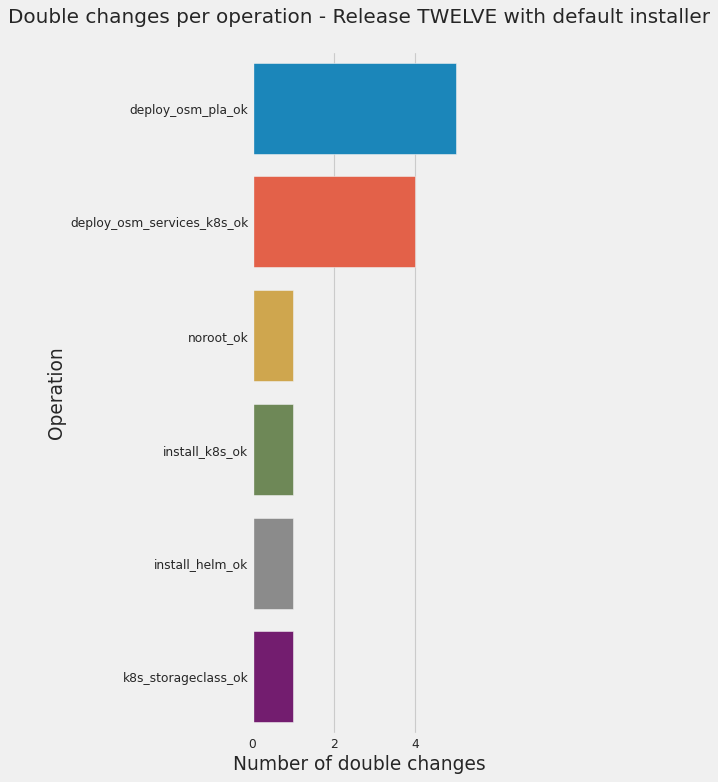

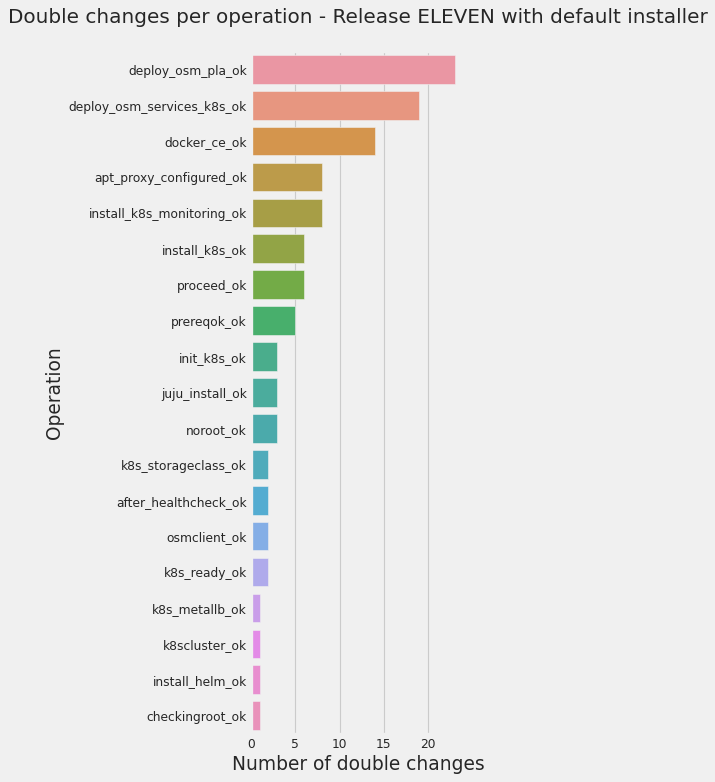


ReleaseTWELVE with charmed installer does not have double changes.



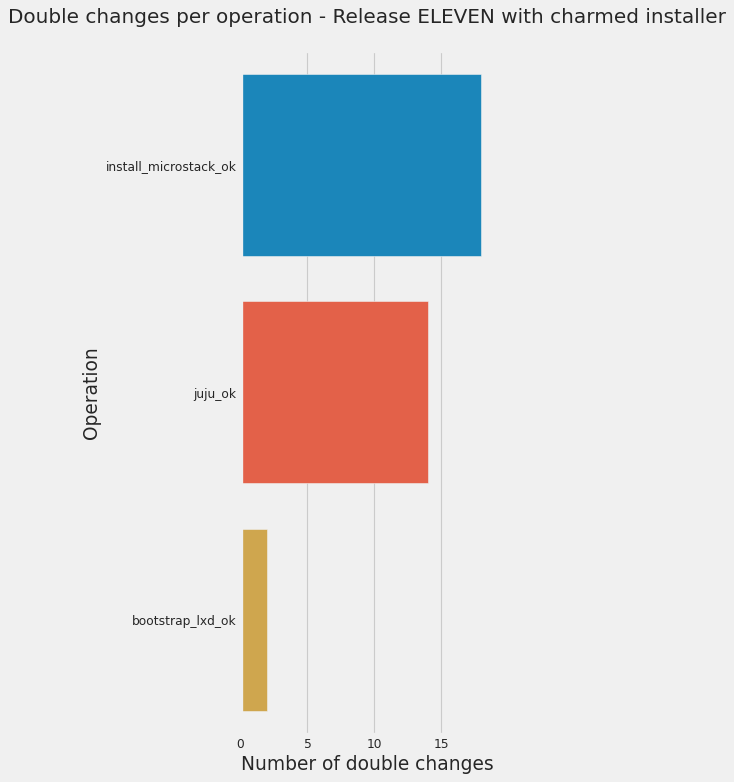

In [77]:
for installer in ['Default', 'Charmed']:
# for installer in ['Default']:
    # for release in [r for r in df_installations_wide.release.unique() if r in relevant_releases]:
    for release in ['ReleaseTWELVE', 'ReleaseELEVEN']:

        # Gets matrix of double changes for a given release and installer
        df_double_changes = (
            df_installations_wide
            .pipe(get_achievement_matrix_per_install_type, release, installer)
            .pipe(get_double_changes_in_installation_sequence)
        )

        # Installation IDs with at least one double change
        installs_with_double_changes = (
            df_double_changes
            .sum(axis=1)
            .sort_values(ascending=False)
            .to_frame(name='count_double_changes')
            .query("count_double_changes > 0")
            .assign(release = release)
            .replace({'release': name_mappings})
            .assign(installer = installer)
        )
        # installs_with_double_changes

        # Number of double changes found per operation
        double_changes_per_operation = (
            df_double_changes
            .sum(axis=0)
            .sort_values(ascending=False)
            .to_frame(name='number_double_changes')
            .reset_index()
            .rename(columns = {'index': 'operation'})
            .query("number_double_changes > 0")
            .assign(release = release)
            .replace({'release': name_mappings})
            .assign(installer = installer)
        )
        # double_changes_per_operation

        # Plots the top operations with doble changes per release and installer
        if len(double_changes_per_operation):
          display(
              _ = plot_double_changes_per_operation(
                double_changes_per_operation,
                f"Double changes per operation - {name_mappings[release]} with {installer.lower()} installer\n"
              )
          )
        else:
          print(f"\n{release} with {installer.lower()} installer does not have double changes.\n")

In [78]:
## Saving the notebook as webpage

In [79]:
if not skip_export_to_html:
    !jupyter nbconvert --to html --output outputs/installation_analysis.html --TemplateExporter.exclude_input=True installation_analysis.ipynb

[NbConvertApp] WARNING | pattern 'installation_analysis.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--e

In [80]:
print('DONE')

DONE


---
